# CS6476 - Segmentation Assignment

# AIM
The aim of this assignment is to implement a U-Net on a biomedical dataset for semantic segmentation.

## Learning Objectives
- Understand data preprocessing for images by using data augmentations.
- Building a custom dataset class for the dataset.
- Understand the architecture of U-Net and implementing various components of U-Net.
- Implement the evaluation metrics for semantic segmentation.
- End-to-end training of U-Net

## Grading Schema
The assignment will be graded out of 16.
- Data Augmentations + Custom Dataset Class (3)
- U-Net architecture + Training (3.5)
- Evaluation metrics (1.5)
- Writeup (8)

### Files to be uploaded on gradescope
- dataset.py
- model.py
- train.py
- utils.py
- run.py

### Google colab setup
First, run the following cell to load the "autoreload" extension. The "autoreload" extension allows you to automatically reload (re-import) Python modules that you've imported or defined when they change. This is particularly useful when you are actively developing or modifying code in external modules and want those changes to be automatically reflected in your notebook without manually restarting the kernel.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
import sys

Run the below cell on Colab. Change this path to the name of your extracted folder on Google Drive. For example: drive/MyDrive/my_folder

In [4]:
%cd drive/MyDrive/'CS 6476 Intro to Computer Vision/Assignment 4'
%ls

/content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 4
Data/       model.py      README.md         run.py     student_submission/  utils.py
dataset.py  __pycache__/  requirements.txt  seg.ipynb  train.py


In [5]:
#after running this block you should see files from the assignment folder
HOME = os.getcwd()
print(os.listdir(HOME))
sys.path.append(HOME)


['README.md', 'requirements.txt', 'Data', 'student_submission', '__pycache__', 'model.py', 'dataset.py', 'train.py', 'utils.py', 'seg.ipynb', 'run.py']


## Install Required Packages

To ensure that all the required Python packages are installed, you can use the following command to install them from the `requirements.txt` file:



In [6]:
!pip install -r requirements.txt

In [7]:
import torch
import torchvision
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm

In [8]:
### Device initialization (If you are using colab, you can change runtime type to gpu)
device = "cuda" if torch.cuda.is_available else "cpu"

In [9]:
### Insert the path to your dataset
train_dir="/content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 4/Data/train"
test_dir="/content/drive/MyDrive/CS 6476 Intro to Computer Vision/Assignment 4/Data/test"


### Data Statistics and Visualization


In this section, we aim to gain a deeper understanding of our dataset by calculating essential statistics and visualizing sample images and their corresponding masks.

Refer to Question 1 (Write-up)



Train image stats: 
Number of Samples: 80
Mean Pixel: 80.11136209170023
Min and Max Height: (512, 512)
Min and Max Width: (512, 512)

Train mask stats: 
Number of Samples: 80
Mean Pixel: 22.343516063690185
Min and Max Height: (512, 512)
Min and Max Width: (512, 512)

Test image stats: 
Number of Samples: 20
Mean Pixel: 80.18198979695639
Min and Max Height: (512, 512)
Min and Max Width: (512, 512)

Test mask stats: 
Number of Samples: 20
Mean Pixel: 22.329174613952638
Min and Max Height: (512, 512)
Min and Max Width: (512, 512)

Visualize 5 Examples with Corresponding Masks:


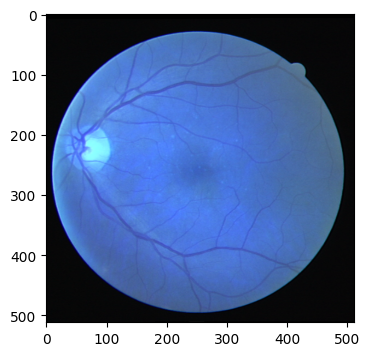

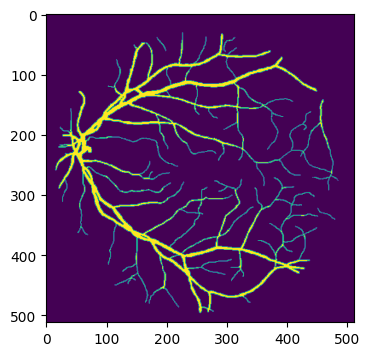

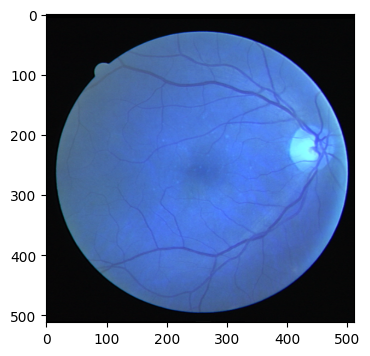

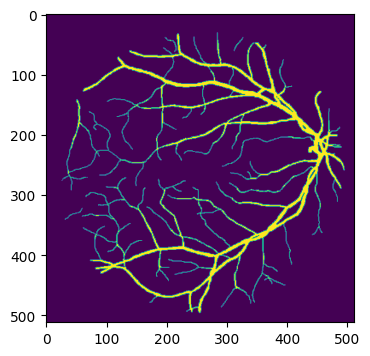

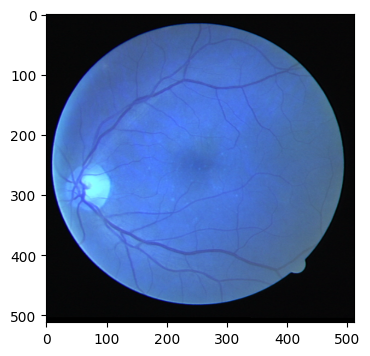

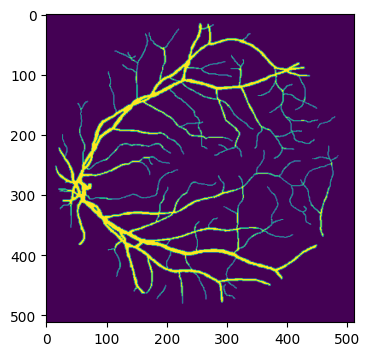

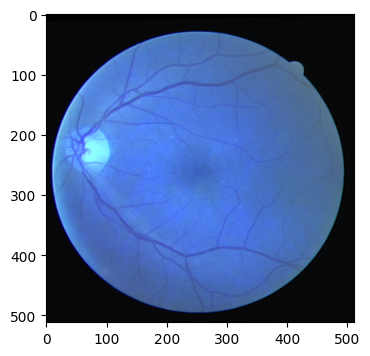

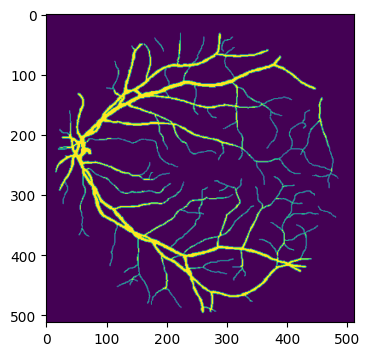

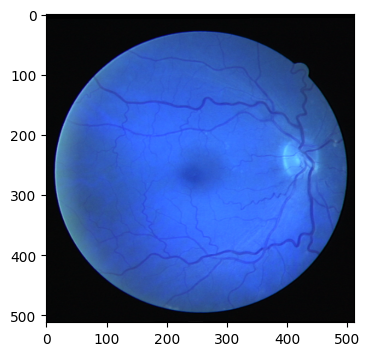

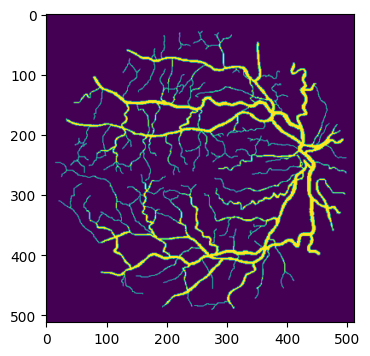

In [10]:
from torch.functional import split
###START YOUR CODE
import os
import cv2
import numpy as np

# Create separate lists for train image and mask data
train_image_data = [0] * 80
train_mask_data = [0] * 80
test_image_data = [0] * 20
test_mask_data = [0] * 20

train_image_size = 0
train_mask_size = 0
test_image_size = 0
test_mask_size = 0

train_image_mean = 0
train_mask_mean = 0
test_image_mean = 0
test_mask_mean = 0

train_image_minh = 100000
train_image_maxh = 0
train_image_minw = 100000
train_image_maxw = 0

train_mask_minh = 100000
train_mask_maxh = 0
train_mask_minw = 100000
train_mask_maxw = 0

test_image_minh = 100000
test_image_maxh = 0
test_image_minw = 100000
test_image_maxw = 0

test_mask_minh = 100000
test_mask_maxh = 0
test_mask_minw = 100000
test_mask_maxw = 0


# Loop through the subdirectories in the training data directory
for subdir in os.listdir(train_dir):
    subdirectory_path = os.path.join(train_dir, subdir)

    if os.path.isdir(subdirectory_path):
        if subdir == 'image':  # Process image subdirectory
            for filename in os.listdir(subdirectory_path):
                file_path = os.path.join(subdirectory_path, filename)
                image = cv2.imread(file_path)
                index, _ = filename.split(".")
                index = int(index)
                #print(index)

                height, width, _ = image.shape
                if(height < train_image_minh):
                  train_image_minh = height

                if(height > train_image_maxh):
                  train_image_maxh = height

                if(width < train_image_minw):
                  train_image_minw = width

                if(width > train_image_maxw):
                  train_image_maxw = width

                # Preprocess the image as needed
                train_image_data[index] = image
                train_image_size+=1

        elif subdir == 'mask':  # Process mask subdirectory
            for filename in os.listdir(subdirectory_path):
                file_path = os.path.join(subdirectory_path, filename)
                mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
                index, _ = filename.split(".")
                index = int(index)
                #print(index)

                height, width = mask.shape
                if(height < train_mask_minh):
                  train_mask_minh = height

                if(height > train_mask_maxh):
                  train_mask_maxh = height

                if(width < train_mask_minw):
                  train_mask_minw = width

                if(width > train_mask_maxw):
                  train_mask_maxw = width

                # Preprocess the mask as needed
                train_mask_data[index] = mask
                train_mask_size +=1




# Loop through the subdirectories in the test data directory
for subdir in os.listdir(test_dir):
    subdirectory_path = os.path.join(test_dir, subdir)

    if os.path.isdir(subdirectory_path):
        if subdir == 'image':  # Process image subdirectory
            for filename in os.listdir(subdirectory_path):
                file_path = os.path.join(subdirectory_path, filename)
                image = cv2.imread(file_path)
                index, _ = filename.split(".")
                index = int(index)

                height, width, _ = image.shape
                if(height < test_image_minh):
                  test_image_minh = height

                if(height > test_image_maxh):
                  test_image_maxh = height

                if(width < test_image_minw):
                  test_image_minw = width

                if(width > test_image_maxw):
                  test_image_maxw = width

                # Preprocess the image as needed
                test_image_data[index] = image
                test_image_size+=1

        elif subdir == 'mask':  # Process mask subdirectory
            for filename in os.listdir(subdirectory_path):
                file_path = os.path.join(subdirectory_path, filename)
                mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
                index, _ = filename.split(".")
                index = int(index)
                #print(index)

                height, width = mask.shape
                if(height < test_mask_minh):
                  test_mask_minh = height

                if(height > test_mask_maxh):
                  test_mask_maxh = height

                if(width < test_mask_minw):
                  test_mask_minw = width

                if(width > test_mask_maxw):
                  test_mask_maxw = width

                # Preprocess the mask as needed
                test_mask_data[index] = mask
                test_mask_size +=1


# Convert the image and mask data to NumPy arrays

train_image_data = np.array(train_image_data)
train_mask_data = np.array(train_mask_data)
test_image_data = np.array(test_image_data)
test_mask_data = np.array(test_mask_data)

train_image_mean = np.mean(train_image_data)
train_mask_mean = np.mean(train_mask_data)
test_image_mean = np.mean(test_image_data)
test_mask_mean = np.mean(test_mask_data)

print("Train image stats: ")
print(f"Number of Samples: {train_image_size}")
print(f"Mean Pixel: {train_image_mean}")
print(f"Min and Max Height: {train_image_minh, train_image_maxh}")
print(f"Min and Max Width: {train_image_minw, train_image_maxw}\n")

print("Train mask stats: ")
print(f"Number of Samples: {train_mask_size}")
print(f"Mean Pixel: {train_mask_mean}")
print(f"Min and Max Height: {train_mask_minh, train_mask_maxh}")
print(f"Min and Max Width: {train_mask_minw, train_mask_maxw}\n")

print("Test image stats: ")
print(f"Number of Samples: {test_image_size}")
print(f"Mean Pixel: {test_image_mean}")
print(f"Min and Max Height: {test_image_minh, test_image_maxh}")
print(f"Min and Max Width: {test_image_minw, test_image_maxw}\n")

print("Test mask stats: ")
print(f"Number of Samples: {test_mask_size}")
print(f"Mean Pixel: {test_mask_mean}")
print(f"Min and Max Height: {test_mask_minh, test_mask_maxh}")
print(f"Min and Max Width: {test_mask_minw, test_mask_maxw}\n")


print("Visualize 5 Examples with Corresponding Masks:")

plt.figure(figsize=(6, 4))
plt.imshow(train_image_data[0])

plt.figure(figsize=(6, 4))
plt.imshow(train_mask_data[0])

plt.figure(figsize=(6, 4))
plt.imshow(train_image_data[1])

plt.figure(figsize=(6, 4))
plt.imshow(train_mask_data[1])

plt.figure(figsize=(6, 4))
plt.imshow(train_image_data[2])

plt.figure(figsize=(6, 4))
plt.imshow(train_mask_data[2])

plt.figure(figsize=(6, 4))
plt.imshow(train_image_data[3])

plt.figure(figsize=(6, 4))
plt.imshow(train_mask_data[3])

plt.figure(figsize=(6, 4))
plt.imshow(train_image_data[4])

plt.figure(figsize=(6, 4))
plt.imshow(train_mask_data[4])

###END YOUR CODE

### Data Augmentations
In this section, we will explore the application of data augmentations using the Python library 'Albumentations.' You can refer to the Albumentations documentation (https://albumentations.ai/docs/) for further details. Go to `utils.py` to complete the function `get_transforms()`.

Define training data augmentation with the following transforms
- Resize to image dimension (512,512).
- Normalize the image with mean of 0 and std of 1 for all channels.
- Add 2 other augmentations of your choice, which you think will better help with our task.

Define test data augmentation with the following transforms
- Resize to image dimension (512,512).
- Normalize the image with mean of 0 and std of 1 for all channels.

Answer Question 2 (Write-up)


### Custom dataset class

In this section, we will implement a custom dataset class, SegDataset using the PyTorch dataset class. Go to `dataset.py` to create your own dataset class.

A custom Dataset class is often needed to prepare and preprocess your data for machine learning tasks. Here's a breakdown of the key methods and concepts in a typical PyTorch Dataset class:

`__init__` Method: This is the constructor method where you initialize the dataset. You typically pass your data (e.g., a list of images or tensors) and an optional transformation function to preprocess the data.

`__len__` Method: This method should return the total number of samples in your dataset. It's used by PyTorch to determine the dataset's size.

`__getitem__` Method: This method defines how individual samples are retrieved from the dataset. You use the provided idx parameter to access data at a specific index. If a transformation function is provided, it's applied to the sample before returning it.


Refer to https://pytorch.org/tutorials/beginner/data_loading_tutorial.html for more details.


When creating an instance of the SegDataset, you need to provide the directory path to the dataset and a pre-defined augmentation transform function. It should return the image and corresponding mask after preprocessing.  

In [11]:
from dataset import SegDataset
from utils import get_transforms

In [12]:
### Loading train and test dataset to check the dataset class implementation
img_height=img_width=512
train_transform, val_transform=get_transforms(img_height, img_width)

train_ds = SegDataset(
        dir=train_dir,
        transform=train_transform,
    )

val_ds = SegDataset(
        dir = test_dir,
        transform=val_transform,
    )

In [13]:
### Define the dataloaders for train and test
train_loader = DataLoader(
        train_ds,
        batch_size=8,
        num_workers=1,
        shuffle=True,
    )


val_loader = DataLoader(
        val_ds,
        batch_size=8,
        num_workers=1,
        shuffle=False,
    )

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])


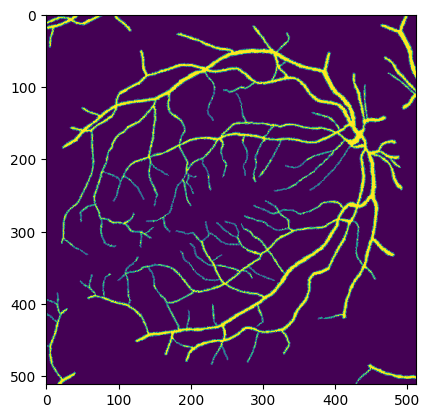

In [14]:
# Do this for sanity checks for the dataloaders (Tip: use this to debug errors in your custom dataset function)
image, mask = next(iter(train_loader))
print(image.shape, mask.shape)
plt.imshow(np.array(image[1].permute(1, 2, 0)))
plt.imshow(np.array(mask[1].permute(1, 2, 0)))


#### Double Convolutional Block


Implement a PyTorch module called DoubleConv for a convolutional neural network.
The DoubleConv module should consist of two sequential convolutional layers, each followed by batch normalization and a ReLU activation function.
        (Conv->Batch_Norm->ReLU->Conv->Batch_Norm->ReLU)

Each convolutional layer should have 3x3 filters, a padding of 1, and no bias. Ensure that the second convolutional layer has the same number of output channels as the first one. The module should be designed to take in an input tensor x and return the result after passing through these layers.

Go to `model.py` to complete this section

### Model Definition

#### U-Net

Implement a UNet architecture for semantic segmentation in PyTorch. The model should consist of two main components: an encoder and a decoder. Please follow these specific instructions for each component:

Encoder: nn.ModuleList [DoubleConv, Double Conv, ...]

- Utilize a series of downsampling blocks, each comprising a DoubleConv module  with increasing numbers of output features (64, 128, 256, 512). These blocks should reduce the spatial dimensions of the input.
- Implement max-pooling with a kernel size of 2x2 and a stride of 2 and apply it after every DoubleConv module in the encoder to reduce the H, W by a factor of 2.


Decoder: nn.ModuleList [ ConvTranspose2d, DoubleConv, nn.ConvTranspose2d, Double Conv, ...]

The decoder should consist of a series of upsampling blocks.
For each block:
- Use a transposed convolution layer (nn.ConvTranspose2d) to upsample the feature maps.
- Employ a DoubleConv module with appropriate input and output channels (matching the output of the transposed convolution).
- Ensure that the upsampling and concatenation of skip connections are handled correctly.

Skip Connections:

To implement skip connections, please:
- Create a list to store encoder outputs for skip connections.
- Before each downsampling step in the encoder, store the encoder output in the list.
- When implementing the decoder, concatenate the stored encoder outputs (skip connections) with the upsampled feature maps at corresponding levels.

Bottleneck:

Implement a bottleneck layer, which is a DoubleConv module whose input and output shape is as shown below. This layer should connect the encoder and decoder.

Input shape: (batch_size, features[-1], H, W)
Output shape: (batch_size, features[-1]*2, H, W)

Final Layer:

Conclude the model with a final convolutional layer that reduces the number of channels to match the desired number of output channels.

Input shape: (batch_size, features[0], H, W)
Output shape: (batch_size, out_channels, H, W)


Go to `model.py` to complete this section

Answer Question 3 (Write-up)

In [15]:
### Check for model
from model import UNET
x = torch.randn((3, 3, 161, 161))
model = UNET(in_channels=3, out_channels=3)
preds = model(x)
preds.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 3, 161, 161])

In [16]:
### Total parameters of the model

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+--------------------------+------------+
|         Modules          | Parameters |
+--------------------------+------------+
|       ups.0.weight       |  2097152   |
|        ups.0.bias        |    512     |
|   ups.1.conv.0.weight    |  4718592   |
|   ups.1.conv.1.weight    |    512     |
|    ups.1.conv.1.bias     |    512     |
|   ups.1.conv.3.weight    |  2359296   |
|   ups.1.conv.4.weight    |    512     |
|    ups.1.conv.4.bias     |    512     |
|       ups.2.weight       |   524288   |
|        ups.2.bias        |    256     |
|   ups.3.conv.0.weight    |  1179648   |
|   ups.3.conv.1.weight    |    256     |
|    ups.3.conv.1.bias     |    256     |
|   ups.3.conv.3.weight    |   589824   |
|   ups.3.conv.4.weight    |    256     |
|    ups.3.conv.4.bias     |    256     |
|       ups.4.weight       |   131072   |
|        ups.4.bias        |    128     |
|   ups.5.conv.0.weight    |   294912   |
|   ups.5.conv.1.weight    |    128     |
|    ups.5.conv.1.bias     |    12

31037763

# Model Training

In this section, we will implement the training process for our semantic segmentation model step by step. We will focus on two key functions: `train_epoch` and `train_unet`. Additionally, we will define the appropriate hyperparameters and loss function for training.

## 1. `train_epoch` Function

The `train_epoch` function is responsible for performing a single pass of training over the entire dataset. Here are the steps for implementing this function:

- Load a batch of training data.
- Forward pass: Feed the data through the model to obtain predictions.
- Compute the loss using an appropriate loss function.
- Backpropagate the gradients and update the model's weights.
- Keep track of training metrics, such as loss and any other relevant information.

## 2. `train_unet` Function

The `train_unet` function will serve as the main training loop. Here, you should define the following:

- Hyperparameters: Set hyperparameters such as learning rate, batch size, and the number of training epochs.
- Loss function: Define the loss function appropriate for your semantic segmentation task (e.g., Cross-Entropy Loss).
- Optimizer: Choose an optimizer, e.g., Adam, to update the model parameters during training.

Inside the `train_unet` function, you will set up a loop to iterate through training epochs. For each epoch:

- Call the `train_epoch` function to train the model on the entire training dataset.
- Print the evaluation metrics by running the `check_accuracy` function.

## 3. `check_accuracy` Function

After each epoch of training, it's essential to evaluate the model's performance. Here's what you should do:

- Implement an evaluation function that calculates metrics such as Pixel Accuracy, Dice Score, and Jaccard Index on a validation dataset.
- Call the evaluation function periodically (e.g., after each epoch or at specific intervals) to monitor the model's progress.

Here, we'll code three important metrics commonly used in semantic segmentation evaluation:

### 1. Pixel Accuracy

**Definition**: Pixel Accuracy measures how accurately the model predicts individual pixels compared to the ground truth. It provides an overall measure of classification accuracy.

**Calculation**: To calculate Pixel Accuracy, we count the number of correctly predicted pixels (where the predicted label matches the ground truth label) and divide it by the total number of pixels in the dataset.

**Formula**: Pixel Accuracy = (Number of Correctly Predicted Pixels) / (Total Number of Pixels)

**Interpretation**: Pixel Accuracy is expressed as a percentage and indicates the proportion of pixels that the model correctly classified. It's a valuable metric for assessing overall image classification performance.

### 2. Dice Score

**Definition**: The Dice Coefficient, often referred to as the Dice Score, quantifies the overlap between predicted and true binary masks. It is particularly vital for assessing how well a segmentation model captures object boundaries.

**Calculation**: The Dice Score is calculated by computing the intersection between the predicted and true binary masks and then normalizing it by the sum of the areas of both masks.

**Formula**: Dice Score = (2 * |Predicted ∩ Ground Truth|) / (|Predicted| + |Ground Truth|)

**Interpretation**: The Dice Score ranges from 0 to 1, where a score of 0 indicates no overlap (poor segmentation), and a score of 1 indicates perfect overlap (excellent segmentation). A higher Dice Score implies better boundary preservation.

### 3. Jaccard Index (IoU - Intersection over Union)

**Definition**: The Intersection over Union (IoU), often referred to as the Jaccard Index, assesses the overlap between the predicted and true binary masks. It offers another perspective on segmentation accuracy.

**Calculation**: The IoU is calculated by dividing the area of the intersection between the predicted and true binary masks by the area of their union.

**Formula**: Jaccard Index (IoU) = |Predicted ∩ Ground Truth| / |Predicted ∪ Ground Truth|

**Interpretation**: Similar to the Dice Score, the Jaccard Index also ranges from 0 to 1, with higher values indicating better segmentation accuracy. It is often used in conjunction with the Dice Score to provide a comprehensive evaluation of segmentation performance.

## Implementation Steps

1. Head over to the `utils.py` file and implement the `check_accuracy` function there.
2. In the `train.py` file, implement the `train_epoch` function as per instructions.
3. In the `run.py` file, implement the `train_unet` function as per instructions.

After finishing the implementations, run the following blocks. After the model has finsihed training plot the graphs for accuracy, dice score, jaccard index vs epochs


### Evaluation function



In [17]:
#import all the functions you just coded
from utils import *
from train import *
from run import train_unet

Epoch 0


Batch Loss: 0.16284582018852234: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Epoch 1


Batch Loss: 0.15600711107254028: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch 2


Batch Loss: 0.13147403299808502: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch 3


Batch Loss: 0.09743735194206238: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Epoch 4


Batch Loss: 0.11509354412555695: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch 5


Batch Loss: 0.1412125527858734: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch 6


Batch Loss: 0.16217131912708282: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Epoch 7


Batch Loss: 0.1723565012216568: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Epoch 8


Batch Loss: 0.14396607875823975: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Epoch 9


Batch Loss: 0.13231642544269562: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch 10


Batch Loss: 0.09504920244216919: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch 11


Batch Loss: 0.12025326490402222: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Epoch 12


Batch Loss: 0.1440734565258026: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Epoch 13


Batch Loss: 0.1636325865983963: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Epoch 14


Batch Loss: 0.15848815441131592: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Epoch 15


Batch Loss: 0.16872859001159668: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Epoch 16


Batch Loss: 0.152610182762146: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch 17


Batch Loss: 0.1339738667011261: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Epoch 18


Batch Loss: 0.10817457735538483: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Epoch 19


Batch Loss: 0.1076200008392334: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


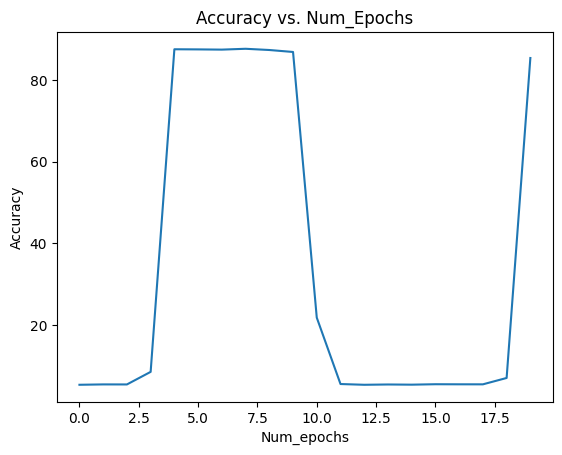

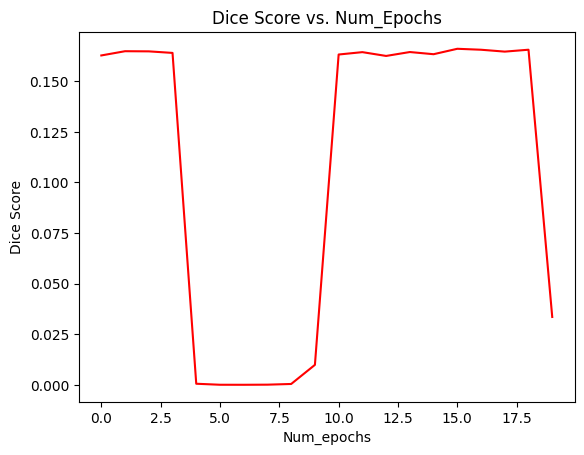

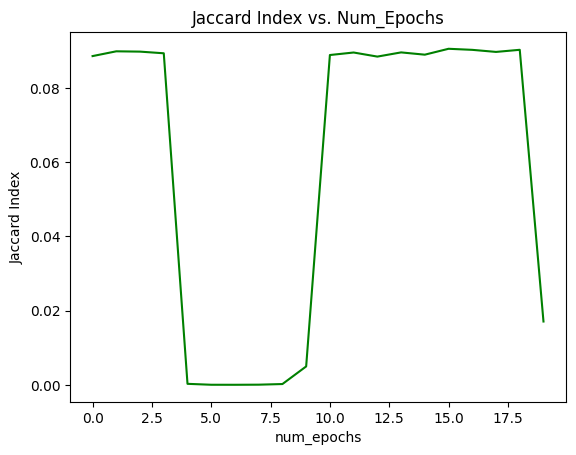

In [18]:
#define a unet model with appropriate input and output channels
model = UNET(in_channels=3, out_channels=1).to(device)
device = "cuda"
#run the training loop
accuracy_history,dice_history,jaccard_history = train_unet(model,device)
num_epochs = np.arange(0,20)
plt.figure()
plt.plot(num_epochs, accuracy_history)
plt.title("Accuracy vs. Num_Epochs")
plt.xlabel("Num_epochs")
plt.ylabel("Accuracy")
plt.figure()
plt.title("Dice Score vs. Num_Epochs")
plt.xlabel("Num_epochs")
plt.ylabel("Dice Score")
plt.plot(num_epochs, dice_history, color = 'red')
plt.figure()
plt.title("Jaccard Index vs. Num_Epochs")
plt.xlabel("num_epochs")
plt.ylabel("Jaccard Index")
plt.plot(num_epochs, jaccard_history, color = 'green')


